In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def Otsu(img, rounds = 1): # img (768H, 512W)
    Masks, th_opts, min_th, max_th = ([], [], np.min(img), np.max(img))

    for rd in range(rounds):
        # Construct 257 bin edges, 256 bin widths, 255 bin widths = max-min
        step = (max_th - min_th)/255
        Otsu_bins = np.arange(min_th-step/2, max_th+step/2+1e-3, step)
        
        cnt, _ = np.histogram(img.flatten(), bins = Otsu_bins)            
        freq, sigma_b_square = (np.zeros((256,)), np.zeros((256,)))
        freq = cnt / np.sum(cnt)
        for k in range(0, 256): # k = 0,1,...,255
            # Background class: [0,k], omega0, mu0
            # Foreground class: [k+1, 255], omega1, mu1
            omega0 = np.sum(freq[0:k+1])
            omega1 = np.sum(freq[k+1:256])
            mu0 = np.sum(freq[0:k+1] * np.arange(0, k+1))
            mu1 = np.sum(freq[k+1:256] * np.arange(k+1, 256))
            sigma_b_square[k] = omega0 * omega1 * (mu0-mu1) * (mu0-mu1)
        k_opt = np.argmax(sigma_b_square)
        min_th = Otsu_bins[k_opt+1]
        Masks.append(((img > min_th)*255).astype("uint8"))
        th_opts.append(min_th)
        #plt.figure(); plt.subplot(211); plt.plot(freq);
        #plt.subplot(212); plt.plot(sigma_b_square); plt.xlabel("k_opt = %d" %k_opt)
    return Masks, th_opts
def TextOpt(img): # img (768H, 512W)
    # moment1 = sum(x)
    # moment2 = sum(x^2)
    # Var = moment2/(N**2) - (moment1/N/N)**2
    img = img.astype("float")
    Ns = [3,5,7]
    re = np.zeros((img.shape[0], img.shape[1], 3))
    for idx_ch, N in enumerate(Ns):
        Diff = int((N-1)/2)
        moment1 = np.zeros((img.shape[0]-N+1, img.shape[1]-N+1))
        moment2 = np.zeros((img.shape[0]-N+1, img.shape[1]-N+1))
        for idx_h in range(N):
            for idx_w in range(N):
                moment1 = moment1 + img[idx_h:idx_h+img.shape[0]-N+1, 
                                        idx_w:idx_w+img.shape[1]-N+1]
                moment2 = moment2 + img[idx_h:idx_h+img.shape[0]-N+1, 
                                        idx_w:idx_w+img.shape[1]-N+1]**2
        re[Diff:-Diff, Diff:-Diff, idx_ch] = moment2/N/N - (moment1/N/N)**2
    return re
def Contour(img): # img (768H, 512W) binary image, 3x3 kernal
    img = img.astype("int")
    moment1 = np.zeros((img.shape[0]-2, img.shape[1]-2))
    for idx_h in range(3):
        for idx_w in range(3):
            if idx_h ==1 and idx_w == 1:
                continue
            moment1 = moment1 + img[idx_h:idx_h+img.shape[0]-2, 
                                    idx_w:idx_w+img.shape[1]-2]
    ContourImg = np.zeros(img.shape)
    ContourImg[1:-1, 1:-1] = np.logical_and(moment1 > 0, moment1 < 8)
    return ContourImg

/home/ran/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


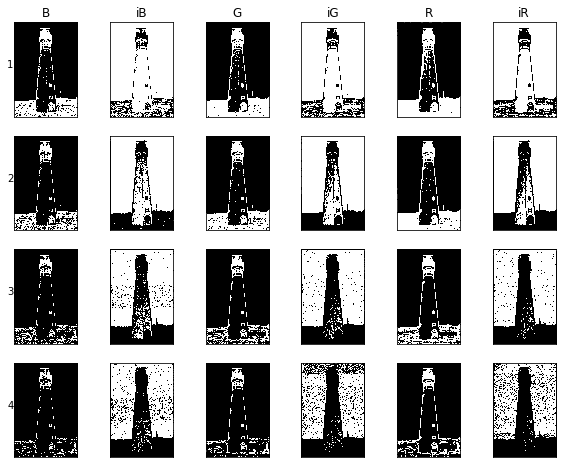

In [2]:
ImgPath = "HW6Pics/lighthouse.jpg"
img = cv2.imread(ImgPath, cv2.IMREAD_GRAYSCALE)   # (768H, 512W) uint8 np ndarray
img = TextOpt(img)
(B, G, R) = (img[:,:,0], img[:,:,1], img[:,:,2])
(iB, iG, iR) = (np.max(img)-B, np.max(img)-G, np.max(img)-R)
plt.figure(figsize=(10,4 * 2))
for c_idx, channel in enumerate([B, iB, G, iG, R, iR]):
    Masks, _ = Otsu(channel, rounds = 4)
    for idx, Mask in enumerate(Masks):
        plt.subplot(4,6, idx*6+c_idx+1)
        plt.imshow(Mask, cmap='gist_gray') # 0 = black, 255 = white
        plt.xticks([])
        plt.yticks([])
plt.subplot(4,6,1); plt.title("B");
plt.subplot(4,6,2); plt.title("iB");
plt.subplot(4,6,3); plt.title("G");
plt.subplot(4,6,4); plt.title("iG");
plt.subplot(4,6,5); plt.title("R");
plt.subplot(4,6,6); plt.title("iR");
for x in range(1,4+1):
    plt.subplot(4,6,6*x-5); plt.ylabel("%d" %x, rotation=0);
plt.savefig("lighthouse_txtdetail.png")

True

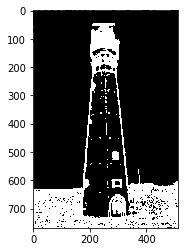

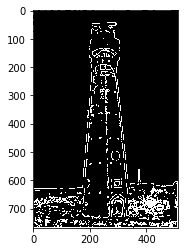

In [3]:
# Choose B @ 1st, G @ 3rd, R@3rd round
Masks_B, _ = Otsu(B, rounds = 3)
Masks_G, _ = Otsu(G, rounds = 3)
Masks_R, _ = Otsu(R, rounds = 3)
Mask = np.logical_or(Masks_B[0]>0, Masks_G[2]>0)
Mask = np.logical_or(Masks_R[2]>0, Mask)
plt.figure()
plt.imshow(Mask, cmap = "gist_gray")
cv2.imwrite("lighthouse_text.png", (Mask*255).astype("uint8"))

ContourImg = Contour(Mask)
plt.figure()
plt.imshow(ContourImg, cmap = "gist_gray")
cv2.imwrite("lighthouse_textContour.png", (ContourImg*255).astype("uint8"))

/home/ran/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


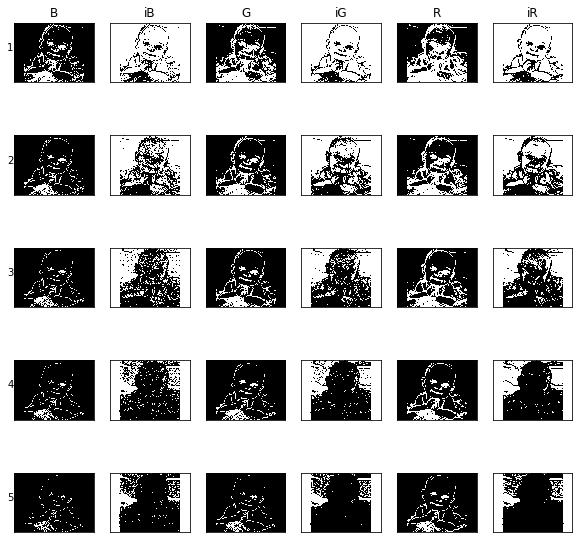

In [4]:
ImgPath = "HW6Pics/baby.jpg"
img = cv2.imread(ImgPath, cv2.IMREAD_GRAYSCALE)   # (768H, 512W) uint8 np ndarray
img = TextOpt(img)
(B, G, R) = (img[:,:,0], img[:,:,1], img[:,:,2])
(iB, iG, iR) = (np.max(img)-B, np.max(img)-G, np.max(img)-R)
plt.figure(figsize=(10,5*2))
for c_idx, channel in enumerate([B, iB, G, iG, R, iR]):
    Masks, _ = Otsu(channel, rounds = 5)
    for idx, Mask in enumerate(Masks):
        plt.subplot(5,6, idx*6+c_idx+1)
        plt.imshow(Mask, cmap='gist_gray') # 0 = black, 255 = white
        plt.xticks([])
        plt.yticks([])
plt.subplot(5,6,1); plt.title("B");
plt.subplot(5,6,2); plt.title("iB");
plt.subplot(5,6,3); plt.title("G");
plt.subplot(5,6,4); plt.title("iG");
plt.subplot(5,6,5); plt.title("R");
plt.subplot(5,6,6); plt.title("iR");
for x in range(1,5+1):
    plt.subplot(5,6,6*x-5); plt.ylabel("%d" %x, rotation=0);
plt.savefig("baby_txtdetail.png")

True

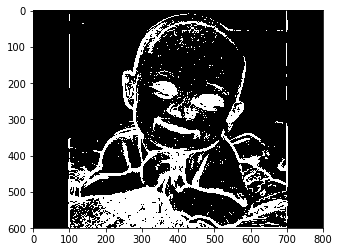

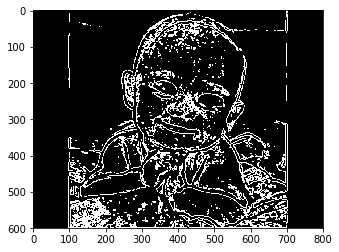

In [5]:
# Choose B @ 1st, G @ 3rd, R@4th round
Masks_B, _ = Otsu(B, rounds = 4)
Masks_G, _ = Otsu(G, rounds = 4)
Masks_R, _ = Otsu(R, rounds = 4)
Mask = np.logical_or(Masks_B[0]>0, Masks_G[2]>0)
Mask = np.logical_or(Masks_R[3]>0, Mask)
plt.figure()
plt.imshow(Mask, cmap = "gist_gray")
cv2.imwrite("baby_text.png", (Mask*255).astype("uint8"))

ContourImg = Contour(Mask)
plt.figure()
plt.imshow(ContourImg, cmap = "gist_gray")
cv2.imwrite("baby_textContour.png", (ContourImg*255).astype("uint8"))

/home/ran/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


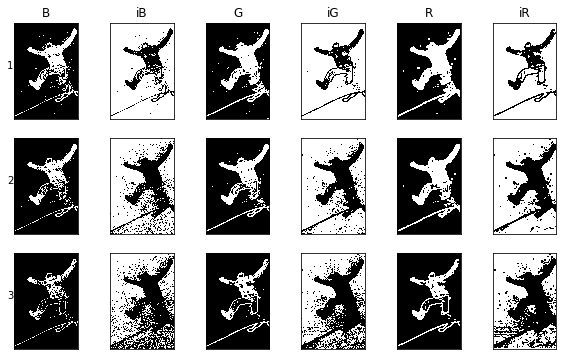

In [6]:
ImgPath = "HW6Pics/ski.jpg"
img = cv2.imread(ImgPath, cv2.IMREAD_GRAYSCALE)   # (768H, 512W) uint8 np ndarray
img = TextOpt(img)
(B, G, R) = (img[:,:,0], img[:,:,1], img[:,:,2])
(iB, iG, iR) = (np.max(img)-B, np.max(img)-G, np.max(img)-R)
plt.figure(figsize=(10,3*2))
for c_idx, channel in enumerate([B, iB, G, iG, R, iR]):
    Masks, _ = Otsu(channel, rounds = 3)
    for idx, Mask in enumerate(Masks):
        plt.subplot(3,6, idx*6+c_idx+1)
        plt.imshow(Mask, cmap='gist_gray') # 0 = black, 255 = white
        plt.xticks([])
        plt.yticks([])
plt.subplot(3,6,1); plt.title("B");
plt.subplot(3,6,2); plt.title("iB");
plt.subplot(3,6,3); plt.title("G");
plt.subplot(3,6,4); plt.title("iG");
plt.subplot(3,6,5); plt.title("R");
plt.subplot(3,6,6); plt.title("iR");
for x in range(1,3+1):
    plt.subplot(3,6,6*x-5); plt.ylabel("%d" %x, rotation=0);
plt.savefig("ski_txtdetail.png")

True

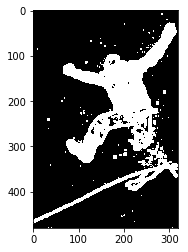

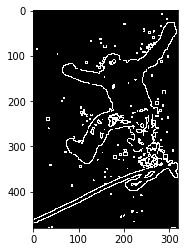

In [7]:
# Choose B @ 1st, G @ 2nd, R@2nd round
Masks_B, _ = Otsu(B, rounds = 2)
Masks_G, _ = Otsu(G, rounds = 2)
Masks_R, _ = Otsu(R, rounds = 2)
Mask = np.logical_or(Masks_B[0]>0, Masks_G[1]>0)
Mask = np.logical_or(Masks_R[1]>0, Mask)
plt.figure()
plt.imshow(Mask, cmap = "gist_gray")
cv2.imwrite("ski_text.png", (Mask*255).astype("uint8"))

ContourImg = Contour(Mask)
plt.figure()
plt.imshow(ContourImg, cmap = "gist_gray")
cv2.imwrite("ski_textContour.png", (ContourImg*255).astype("uint8"))